In [0]:
# CELL 1: environment & catalog checks
from pyspark.sql import functions as F
spark = spark  # using existing session

print("Spark version:", spark.version)
current_db = spark.catalog.currentDatabase()
print("Current database:", current_db)

print("\nTables in current DB:")
spark.sql(f"SHOW TABLES IN {current_db}").show(truncate=False)

# search for table prod_predictions across all databases
print("\nSearching all databases for 'prod_predictions' ...")
dbs = [row.databaseName for row in spark.sql("SHOW DATABASES").collect()]
found = []
for db in dbs:
    df = spark.sql(f"SHOW TABLES IN {db}")
    if df.filter(F.col("tableName") == "prod_predictions").count() > 0:
        found.append(db)

if found:
    print("prod_predictions found in these databases:", found)
    for db in found:
        print(f"Describe table in {db}.prod_predictions:")
        try:
            spark.sql(f"DESCRIBE DETAIL {db}.prod_predictions").show(truncate=False)
        except Exception as e:
            print("Could not DESCRIBE DETAIL (maybe permissions):", e)
else:
    print("prod_predictions not found in any catalog database.")


Spark version: 4.0.0
Current database: default

Tables in current DB:
+--------+----------------+-----------+
|database|tableName       |isTemporary|
+--------+----------------+-----------+
|default |ml_drift_summary|false      |
|default |prod_predictions|false      |
+--------+----------------+-----------+


Searching all databases for 'prod_predictions' ...
prod_predictions found in these databases: ['default']
Describe table in default.prod_predictions:
+------+------------------------------------+----------------------------------+-----------+--------+----------------------+-------------------+----------------+-----------------+--------+-----------+-------------------------------------+----------------+----------------+-----------------------------------------+---------------------------------------------------------------+-------------+
|format|id                                  |name                              |description|location|createdAt             |lastModified       |p

In [0]:
# CELL 2: create a safe test table (only if missing)
from datetime import date, timedelta
import pandas as pd
import random
spark = spark

def ensure_test_table(table_name="prod_predictions", rows_per_day=50, days=30):
    # check existence in current DB
    current_db = spark.catalog.currentDatabase()
    tbls = spark.sql(f"SHOW TABLES IN {current_db}").toPandas()
    if "prod_predictions" in tbls["tableName"].values:
        print(f"Table '{current_db}.prod_predictions' already exists — skipping creation.")
        return f"{current_db}.prod_predictions"
    print(f"Creating test delta table '{current_db}.prod_predictions' with {rows_per_day*days} rows ...")
    today = date.today()
    rows = []
    for d in range(1, days+1):
        day = (today - timedelta(days=d)).isoformat()
        for i in range(rows_per_day):
            rows.append({
                "event_date": day,
                "txn_amount": float(max(0, random.gauss(60, 25))),
                "model_score": float(random.random()),
                "request_id": f"req_{d}_{i}"
            })
    pdf = pd.DataFrame(rows)
    sdf = spark.createDataFrame(pdf)
    # write as managed delta table in current DB
    sdf.write.format("delta").mode("overwrite").saveAsTable("prod_predictions")
    print("Created prod_predictions.")
    return f"{current_db}.prod_predictions"

table_fqn = ensure_test_table()
print("Table created/confirmed:", table_fqn)


Table 'default.prod_predictions' already exists — skipping creation.
Table created/confirmed: default.prod_predictions


In [0]:
# CELL 2b: scalable synthetic data (use if you need larger dataset)
from pyspark.sql.functions import expr, rand, floor, col, current_date, date_sub
spark = spark

def create_large_table(table_name="prod_predictions_large", n_rows=2_000_000, lookback_days=60):
    print(f"Creating scalable dataset '{table_name}' with approx {n_rows} rows ...")
    sdf = spark.range(0, n_rows).withColumn("event_date", expr(f"date_sub(current_date(), cast(rand()*{lookback_days} as int))")) \
                                .withColumn("txn_amount", (rand() * 500)) \
                                .withColumn("model_score", rand()) \
                                .withColumn("request_id", expr("concat('req_', id)")) \
                                .drop("id")
    sdf.write.format("delta").mode("overwrite").saveAsTable(table_name)
    print("Created scalable table:", table_name)

# Example call (comment/uncomment to use: careful with very large n_rows on community)
# create_large_table(table_name="prod_predictions_large", n_rows=200000, lookback_days=60)


In [0]:
# CELL 3: describe schema and show samples
table_name = "prod_predictions"  # change to db.prod_predictions if found earlier
print("Current DB:", spark.catalog.currentDatabase())
print("DESCRIBE TABLE:")
spark.sql(f"DESCRIBE TABLE {table_name}").show(truncate=False)

print("\nDESCRIBE DETAIL (if available):")
try:
    spark.sql(f"DESCRIBE DETAIL {table_name}").show(truncate=False)
except Exception as e:
    print("DESCRIBE DETAIL failed:", e)

print("\nSample rows (10):")
spark.sql(f"SELECT * FROM {table_name} ORDER BY event_date DESC LIMIT 10").show(truncate=False)
print("\nCounts per date (recent 7):")
spark.sql(f"""
  SELECT event_date, count(*) as cnt
  FROM {table_name}
  GROUP BY event_date
  ORDER BY event_date DESC
  LIMIT 7
""").show(truncate=False)


Current DB: default
DESCRIBE TABLE:
+-----------+---------+-------+
|col_name   |data_type|comment|
+-----------+---------+-------+
|event_date |string   |NULL   |
|txn_amount |double   |NULL   |
|model_score|double   |NULL   |
|request_id |string   |NULL   |
+-----------+---------+-------+


DESCRIBE DETAIL (if available):
+------+------------------------------------+----------------------------------+-----------+--------+----------------------+-------------------+----------------+-----------------+--------+-----------+-------------------------------------+----------------+----------------+-----------------------------------------+---------------------------------------------------------------+-------------+
|format|id                                  |name                              |description|location|createdAt             |lastModified       |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties                           |minReaderVersion|minWriterVersion|tableFeat

In [0]:
# CELL 4: window selection and counts
from datetime import date, timedelta
spark = spark

REFERENCE_WINDOW_DAYS = 30
CURRENT_WINDOW_DAYS = 7
today = date.today()
ref_start = (today - timedelta(days=REFERENCE_WINDOW_DAYS)).isoformat()
ref_end   = (today - timedelta(days=CURRENT_WINDOW_DAYS+1)).isoformat()
cur_start = (today - timedelta(days=CURRENT_WINDOW_DAYS)).isoformat()
cur_end   = today.isoformat()

print("Reference window:", ref_start, "->", ref_end)
print("Current window:", cur_start, "->", cur_end)

table_name = "prod_predictions"

baseline_count = spark.sql(f"SELECT count(*) as cnt FROM {table_name} WHERE event_date >= '{ref_start}' AND event_date <= '{ref_end}'").collect()[0][0]
current_count = spark.sql(f"SELECT count(*) as cnt FROM {table_name} WHERE event_date >= '{cur_start}' AND event_date <= '{cur_end}'").collect()[0][0]
print("Baseline count:", baseline_count)
print("Current count: ", current_count)


Reference window: 2025-09-04 -> 2025-09-26
Current window: 2025-09-27 -> 2025-10-04
Baseline count: 1150
Current count:  100


In [0]:
# CELL 5: helpers for binning, freqs, and PSI
import math
from pyspark.sql import functions as F
# Replacement bucketize_df using a Python UDF (works reliably across Databricks versions)
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def compute_quantile_bins(ref_df, col, n_bins=10, relative_error=0.01):
    probs = [i / n_bins for i in range(n_bins + 1)]
    q = ref_df.approxQuantile(col, probs, relative_error)
    # sanitize monotonic bins
    bins = []
    last = -float("inf")
    for v in q:
        if v is None:
            continue
        if v <= last:
            v = last + 1e-9
        bins.append(float(v))
        last = v
    if not bins:
        return [-float("inf"), float("inf")]
    bins[0] = -float("inf")
    if bins[-1] != float("inf"):
        bins[-1] = float("inf")
    return bins

def make_bucket_udf(bins):
    # bins = list of floats with -inf as -float('inf') and +inf as float('inf')
    def bucket_val(v):
        if v is None:
            return None
        try:
            vv = float(v)
        except:
            return None
        for i in range(len(bins)-1):
            low = bins[i]
            high = bins[i+1]
            if low == -float("inf"):
                if vv <= high:
                    return f"(-inf,{high}]"
            elif high == float("inf"):
                if vv > low:
                    return f"({low},inf)"
            else:
                # open on left, closed on right as in prior code
                if vv > low and vv <= high:
                    return f"({low},{high}]"
        return None
    return udf(bucket_val, StringType())

def bucketize_df_udf(df, col, bins):
    """
    df: Spark DataFrame
    col: column name to bucketize
    bins: Python list of floats (first should be -inf, last +inf)
    returns: DataFrame with new column '<col>_bin'
    """
    bucket_udf = make_bucket_udf(bins)
    return df.withColumn(f"{col}_bin", bucket_udf(F.col(col)))

def bucketize_df(df, col, bins, out_col_suffix="_bin"):
    expr = None
    out_col = f"{col}{out_col_suffix}"
    for i in range(len(bins)-1):
        low = bins[i]
        high = bins[i+1]
        if low == -float("inf"):
            cond = F.col(col) <= F.lit(high)
            label = f"(-inf,{high}]"
        elif high == float("inf"):
            cond = F.col(col) > F.lit(low)
            label = f"({low},inf)"
        else:
            cond = (F.col(col) > F.lit(low)) & (F.col(col) <= F.lit(high))
            label = f"({low},{high}]"
        when = F.when(cond, F.lit(label))
        expr = when if expr is None else expr.otherwise(when)
    return df.withColumn(out_col, expr)

def freqs(df, bincol):
    total = df.count()
    if total == 0:
        return {}
    rows = df.groupBy(bincol).count().toPandas()
    freqs = {}
    for _, r in rows.iterrows():
        freqs[r[bincol]] = float(r['count']) / float(total)
    return freqs

def psi_from_freqs(baseline_freqs: dict, current_freqs: dict, eps=1e-8):
    all_keys = set(baseline_freqs.keys()).union(set(current_freqs.keys()))
    psi = 0.0
    for k in all_keys:
        b = baseline_freqs.get(k, eps)
        c = current_freqs.get(k, eps)
        b = max(b, eps)
        c = max(c, eps)
        psi += (b - c) * math.log(b / c)
    return float(psi)


In [0]:
# Diagnostic + safe write for ml_drift_summary (copy -> paste -> run in new cell)
from pyspark.sql import functions as F
import traceback

print("events_sdf schema (to write):")
events_sdf.printSchema()

table_name = "ml_drift_summary"
table_exists = False
try:
    spark.table(table_name)
    table_exists = True
    print(f"\nTable '{table_name}' exists. Current schema:")
    spark.table(table_name).printSchema()
except Exception:
    print(f"\nTable '{table_name}' does not exist yet. We'll create it.")

try:
    if table_exists:
        print("\nAttempting to append to existing table...")
        events_sdf.write.format("delta").mode("append").saveAsTable(table_name)
        print("Append succeeded.")
    else:
        print("\nTable does not exist — writing new table with overwrite mode.")
        events_sdf.write.format("delta").mode("overwrite").saveAsTable(table_name)
        print("Table created.")
except Exception:
    print("\nAppend failed — attempting overwrite with schema overwrite.")
    traceback.print_exc()
    events_sdf.write.format("delta").option("overwriteSchema","true").mode("overwrite").saveAsTable(table_name)
    print("Overwrite with schema overwrite succeeded.")

print("\nFinal table schema & sample rows for ml_drift_summary:")
t = spark.table(table_name)
t.printSchema()
display(t.orderBy(F.desc("window_start")).limit(20).toPandas())


events_sdf schema (to write):
root
 |-- feature: string (nullable = true)
 |-- baseline_n: double (nullable = true)
 |-- current_n: double (nullable = true)
 |-- psi: double (nullable = true)
 |-- null_rate_change: double (nullable = true)
 |-- window_start: string (nullable = true)
 |-- window_end: string (nullable = true)


Table 'ml_drift_summary' exists. Current schema:
root
 |-- feature: string (nullable = true)
 |-- baseline_n: double (nullable = true)
 |-- current_n: double (nullable = true)
 |-- psi: double (nullable = true)
 |-- null_rate_change: double (nullable = true)
 |-- window_start: string (nullable = true)
 |-- window_end: string (nullable = true)


Attempting to append to existing table...
Append succeeded.

Final table schema & sample rows for ml_drift_summary:
root
 |-- feature: string (nullable = true)
 |-- baseline_n: double (nullable = true)
 |-- current_n: double (nullable = true)
 |-- psi: double (nullable = true)
 |-- null_rate_change: double (nullable = true)

feature,baseline_n,current_n,psi,null_rate_change,window_start,window_end
txn_amount,1150.0,100.0,0.151988,0.0,2025-09-27,2025-10-04
model_score,1150.0,100.0,0.180849,0.0,2025-09-27,2025-10-04
model_score,1150.0,100.0,0.180849,0.0,2025-09-27,2025-10-04
model_score,1150.0,100.0,0.180849,0.0,2025-09-27,2025-10-04
txn_amount,1150.0,100.0,0.151988,0.0,2025-09-27,2025-10-04
txn_amount,1150.0,100.0,0.151988,0.0,2025-09-27,2025-10-04


In [0]:
# CELL 6 (REPLACEMENT) - compute drift summary and write audit table
# --- Ensure you have already executed CELL 5 (helpers) and CELL 5a (bucketize_df_udf) ---
import pandas as pd
from pyspark.sql import functions as F

table_name = "prod_predictions"

# confirm table exists
try:
    spark.table(table_name)
except Exception as e:
    raise RuntimeError(f"Table '{table_name}' not found in current catalog. Run CELL 2 to create it or qualify the db: {e}")

# pick monitoring columns
cols = [c.name for c in spark.table(table_name).schema.fields]
monitor_cols = []
if "model_score" in cols:
    monitor_cols.append("model_score")
if "txn_amount" in cols:
    monitor_cols.append("txn_amount")
if not monitor_cols:
    numeric_cols = [c.name for c in spark.table(table_name).schema.fields if "DoubleType" in str(c.dataType) or "IntegerType" in str(c.dataType)]
    monitor_cols = numeric_cols[:2] if numeric_cols else cols[:1]

print("Monitoring columns:", monitor_cols)

# window bounds from earlier cells
# ensure ref_start, ref_end, cur_start, cur_end are defined (from CELL 4)
try:
    _ = ref_start; _ = ref_end; _ = cur_start; _ = cur_end
except NameError:
    from datetime import date, timedelta
    today = date.today()
    REF_DAYS = 30
    CUR_DAYS = 7
    ref_start = (today - timedelta(days=REF_DAYS)).isoformat()
    ref_end   = (today - timedelta(days=CUR_DAYS+1)).isoformat()
    cur_start = (today - timedelta(days=CUR_DAYS)).isoformat()
    cur_end   = today.isoformat()

print("Reference window:", ref_start, "->", ref_end)
print("Current window:  ", cur_start, "->", cur_end)

# load windowed DataFrames safely using spark.sql (no stray characters)
baseline_df = spark.sql(f"SELECT * FROM {table_name} WHERE event_date >= '{ref_start}' AND event_date <= '{ref_end}'")
current_df  = spark.sql(f"SELECT * FROM {table_name} WHERE event_date >= '{cur_start}' AND event_date <= '{cur_end}'")

print("Baseline rows:", baseline_df.count())
print("Current  rows:", current_df.count())

# compute drift stats
results = []
MIN_SAMPLE_FOR_TESTS = 50

for col in monitor_cols:
    try:
        bcnt = baseline_df.filter(F.col(col).isNotNull()).count()
        ccnt = current_df.filter(F.col(col).isNotNull()).count()
        if bcnt < MIN_SAMPLE_FOR_TESTS or ccnt < MIN_SAMPLE_FOR_TESTS:
            results.append({"feature":col, "baseline_n": bcnt, "current_n": ccnt, "psi": None, "null_rate_change": None})
            continue

        # compute bins from baseline using compute_quantile_bins defined in CELL 5
        bins = compute_quantile_bins(baseline_df.filter(F.col(col).isNotNull()), col, n_bins=10)
        # use UDF-based bucketizer: bucketize_df_udf
        b_buckets = bucketize_df_udf(baseline_df.filter(F.col(col).isNotNull()), col, bins)
        c_buckets = bucketize_df_udf(current_df.filter(F.col(col).isNotNull()), col, bins)
        b_freqs = freqs(b_buckets, f"{col}_bin")
        c_freqs = freqs(c_buckets, f"{col}_bin")
        psi = psi_from_freqs(b_freqs, c_freqs)

        b_null_rate = 1.0 - (bcnt / max(1, baseline_df.count()))
        c_null_rate = 1.0 - (ccnt / max(1, current_df.count()))
        null_rate_change = c_null_rate - b_null_rate

        results.append({"feature": col, "baseline_n": bcnt, "current_n": ccnt, "psi": round(psi,6), "null_rate_change": round(null_rate_change,6)})
    except Exception as e:
        results.append({"feature": col, "error": str(e)})

# display results
res_df = pd.DataFrame(results)
print("Drift summary:")
display(res_df)

# write audit to delta table ml_drift_summary (create if missing)
events = []
for r in results:
    events.append({
        "feature": r.get("feature"),
        "baseline_n": float(r.get("baseline_n") or 0),
        "current_n": float(r.get("current_n") or 0),
        "psi": float(r.get("psi")) if r.get("psi") is not None else None,
        "null_rate_change": float(r.get("null_rate_change")) if r.get("null_rate_change") is not None else None,
        "window_start": cur_start,
        "window_end": cur_end
    })

events_sdf = spark.createDataFrame(pd.DataFrame(events))
try:
    spark.table("ml_drift_summary")
    events_sdf.write.format("delta").mode("append").saveAsTable("ml_drift_summary")
except Exception:
    events_sdf.write.format("delta").mode("overwrite").saveAsTable("ml_drift_summary")

print("Appended/created ml_drift_summary - query: SELECT * FROM ml_drift_summary ORDER BY window_start DESC")


Monitoring columns: ['model_score', 'txn_amount']
Reference window: 2025-09-04 -> 2025-09-26
Current window:   2025-09-27 -> 2025-10-04
Baseline rows: 1150
Current  rows: 100
Drift summary:


feature,baseline_n,current_n,psi,null_rate_change
model_score,1150,100,0.180849,0.0
txn_amount,1150,100,0.151988,0.0


Appended/created ml_drift_summary - query: SELECT * FROM ml_drift_summary ORDER BY window_start DESC


# POC Plan — Drift Monitoring (A / B / C)
Goal: produce drift summary into Delta (`ml_drift_summary`) and support Splunk ingestion later.

A — Monitoring & Visualization
 - compute PSI/KS/chi2 per feature, store in `ml_drift_summary`
 - create small visualization in notebook and instructions for Databricks SQL dashboards

B — ML-Ops enrichment
 - extend to multiple features (numerical + categorical)
 - join labels (if available) and compute AUC/accuracy; store `ml_perf_summary`

C — Explainability & RCA
 - compute per-bin PSI contributions and store `ml_drift_contributions`
 - generate alerts (psi_threshold) and optionally push to Splunk/Slack

Run each code cell after pasting into its own notebook cell.


In [0]:
# CELL 7 as per POC PLAN
# CELL A1 — Utilities: quantile bins, UDF bucketing, freqs, PSI, KS, Chi2
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
import math, numpy as np, pandas as pd

def compute_quantile_bins(ref_df, col, n_bins=10, relative_error=0.01):
    # returns Python list of bin boundaries with -inf and +inf as endpoints
    probs = [i / n_bins for i in range(n_bins + 1)]
    q = ref_df.approxQuantile(col, probs, relative_error)
    bins = []
    last = -float("inf")
    for v in q:
        if v is None:
            continue
        if v <= last:
            v = last + 1e-9
        bins.append(float(v))
        last = v
    if not bins:
        return [-float("inf"), float("inf")]
    bins[0] = -float("inf")
    if bins[-1] != float("inf"):
        bins[-1] = float("inf")
    return bins

def make_bucket_udf(bins):
    def bucket_val(v):
        if v is None:
            return None
        try:
            vv = float(v)
        except:
            return None
        for i in range(len(bins)-1):
            low = bins[i]
            high = bins[i+1]
            if low == -float("inf"):
                if vv <= high:
                    return f"(-inf,{high}]"
            elif high == float("inf"):
                if vv > low:
                    return f"({low},inf)"
            else:
                if vv > low and vv <= high:
                    return f"({low},{high}]"
        return None
    return udf(bucket_val, StringType())

def bucketize_df_udf(df, col, bins):
    bucket_udf = make_bucket_udf(bins)
    return df.withColumn(f"{col}_bin", bucket_udf(F.col(col)))

def freqs(df, bincol):
    total = df.count()
    if total == 0:
        return {}
    rows = df.groupBy(bincol).count().toPandas()
    freqs = {}
    for _, r in rows.iterrows():
        freqs[r[bincol]] = float(r['count']) / float(total)
    return freqs

def psi_from_freqs(baseline_freqs: dict, current_freqs: dict, eps=1e-8):
    all_keys = set(baseline_freqs.keys()).union(set(current_freqs.keys()))
    psi = 0.0
    for k in all_keys:
        b = baseline_freqs.get(k, eps)
        c = current_freqs.get(k, eps)
        b = max(b, eps)
        c = max(c, eps)
        psi += (b - c) * math.log(b / c)
    return float(psi)

def ks_test_approx(baseline_df, current_df, col, sample_size=2000):
    b_count = baseline_df.count()
    c_count = current_df.count()
    if b_count < 2 or c_count < 2:
        return None
    b_samp = baseline_df.select(col).where(F.col(col).isNotNull()).limit(sample_size).toPandas()[col].values
    c_samp = current_df.select(col).where(F.col(col).isNotNull()).limit(sample_size).toPandas()[col].values
    if len(b_samp)==0 or len(c_samp)==0:
        return None
    data_all = np.sort(np.concatenate([b_samp, c_samp]))
    cdf_b = np.searchsorted(np.sort(b_samp), data_all, side='right')/float(len(b_samp))
    cdf_c = np.searchsorted(np.sort(c_samp), data_all, side='right')/float(len(c_samp))
    d = float(np.max(np.abs(cdf_b - cdf_c)))
    return {"D_stat": d}

def chi2_test_from_counts(baseline_counts: dict, current_counts: dict):
    # baseline_counts & current_counts are maps category -> count (absolute)
    # compute expected = baseline_prop * current_total
    cur_total = sum(current_counts.values())
    base_total = sum(baseline_counts.values())
    if base_total == 0 or cur_total == 0:
        return None
    chi2 = 0.0
    for k, cur_obs in current_counts.items():
        base_count = baseline_counts.get(k, 0)
        exp = (base_count / base_total) * cur_total
        # avoid zero expected
        if exp <= 0:
            continue
        chi2 += (cur_obs - exp)**2 / exp
    df = max(len(set(list(baseline_counts.keys()) + list(current_counts.keys()))) - 1, 1)
    return {"chi2_stat": float(chi2), "df": int(df)}


In [0]:
# CELL 8 - As per POC PLAN CELL A2
# CELL A2 — get_drift_summary
from pyspark.sql import functions as F

def get_drift_summary(
    delta_table="prod_predictions",
    reference_days=30,
    current_days=7,
    n_bins=10,
    min_sample=50,
    monitor_cols=None
):
    """
    Returns: events_sdf (spark df of summary per feature) and contributions_sdf (per-bin psi components)
    """
    from datetime import date, timedelta
    today = date.today()
    ref_start = (today - timedelta(days=reference_days)).isoformat()
    ref_end   = (today - timedelta(days=current_days+1)).isoformat()
    cur_start = (today - timedelta(days=current_days)).isoformat()
    cur_end   = today.isoformat()

    # read table
    full = spark.read.format("delta").table(delta_table)
    full = full.withColumn("event_date", F.to_date(F.col("event_date")))
    baseline_df = full.filter((F.col("event_date") >= F.lit(ref_start)) & (F.col("event_date") <= F.lit(ref_end)))
    current_df  = full.filter((F.col("event_date") >= F.lit(cur_start)) & (F.col("event_date") <= F.lit(cur_end)))

    # choose monitor columns automatically if not provided
    cols = [c.name for c in full.schema.fields]
    if monitor_cols is None:
        monitor_cols = []
        if "model_score" in cols: monitor_cols.append("model_score")
        if "txn_amount" in cols: monitor_cols.append("txn_amount")
        if not monitor_cols:
            numeric_cols = [c.name for c in full.schema.fields if "DoubleType" in str(c.dataType) or "IntegerType" in str(c.dataType)]
            monitor_cols = numeric_cols[:3] if numeric_cols else cols[:1]

    results = []
    contrib_rows = []

    for col in monitor_cols:
        try:
            bcnt = baseline_df.filter(F.col(col).isNotNull()).count()
            ccnt = current_df.filter(F.col(col).isNotNull()).count()
            if bcnt < min_sample or ccnt < min_sample:
                results.append({"feature": col, "baseline_n": bcnt, "current_n": ccnt, "psi": None, "ks": None, "chi2": None, "null_rate_change": None, "window_start": cur_start, "window_end": cur_end})
                continue

            # numeric handling
            # compute bins from baseline
            bins = compute_quantile_bins(baseline_df.filter(F.col(col).isNotNull()), col, n_bins=n_bins)
            b_buckets = bucketize_df_udf(baseline_df.filter(F.col(col).isNotNull()), col, bins)
            c_buckets = bucketize_df_udf(current_df.filter(F.col(col).isNotNull()), col, bins)
            b_freqs = freqs(b_buckets, f"{col}_bin")
            c_freqs = freqs(c_buckets, f"{col}_bin")
            psi = psi_from_freqs(b_freqs, c_freqs)

            # compute per-bin psi contributions for explainability
            all_bins = sorted(set(list(b_freqs.keys()) + list(c_freqs.keys())))
            for bkt in all_bins:
                b_pct = b_freqs.get(bkt, 1e-8)
                c_pct = c_freqs.get(bkt, 1e-8)
                comp = (b_pct - c_pct) * math.log(b_pct / c_pct) if b_pct>0 and c_pct>0 else 0.0
                contrib_rows.append({"feature": col, "bin": bkt, "baseline_pct": b_pct, "current_pct": c_pct, "psi_component": float(comp), "window_start": cur_start, "window_end": cur_end})

            # KS
            ks = ks_test_approx(baseline_df, current_df, col)

            # null rates
            b_null_rate = 1.0 - (bcnt / max(1, baseline_df.count()))
            c_null_rate = 1.0 - (ccnt / max(1, current_df.count()))
            null_rate_change = c_null_rate - b_null_rate

            # for categorical fallback (if small distinct count), compute chi2 against baseline freq
            # get categorical counts if dtype suggests string or low cardinality
            unique_count = baseline_df.select(col).distinct().count()
            chi2 = None
            if unique_count < 50 and not isinstance(bins[0], float) or unique_count < 50:
                b_counts = {r[0]: r[1] for r in baseline_df.groupBy(col).count().collect()}
                c_counts = {r[0]: r[1] for r in current_df.groupBy(col).count().collect()}
                chi2 = chi2_test_from_counts(b_counts, c_counts)

            results.append({"feature": col, "baseline_n": bcnt, "current_n": ccnt, "psi": round(psi,6) if psi is not None else None, "ks": ks, "chi2": chi2, "null_rate_change": round(null_rate_change,6), "window_start": cur_start, "window_end": cur_end})
        except Exception as e:
            results.append({"feature": col, "error": str(e), "window_start": cur_start, "window_end": cur_end})

    events_pdf = pd.DataFrame(results)
    events_sdf = spark.createDataFrame(events_pdf)

    contrib_pdf = pd.DataFrame(contrib_rows) if contrib_rows else pd.DataFrame(columns=["feature","bin","baseline_pct","current_pct","psi_component","window_start","window_end"])
    contributions_sdf = spark.createDataFrame(contrib_pdf)

    return events_sdf, contributions_sdf


In [0]:
# REPLACEMENT CELL A3 : generate drift summary, normalize and FORCE-WRITE to *_v2 tables
from pyspark.sql import functions as F
import pandas as pd, traceback

# 1) Generate (or reuse) events_sdf, contributions_sdf
try:
    # if you already have events_sdf from prior cell, this will skip recomputing
    events_sdf, contributions_sdf
    print("events_sdf already in memory — reusing.")
except NameError:
    print("Calling get_drift_summary(...) now to produce events_sdf & contributions_sdf")
    events_sdf, contributions_sdf = get_drift_summary(delta_table="prod_predictions", reference_days=30, current_days=7, n_bins=10, min_sample=50)

# 2) Normalize: ensure ks/chi2 are strings and collected_at exists
for colname in ("ks", "chi2"):
    if colname in events_sdf.columns:
        events_sdf = events_sdf.withColumn(colname, F.col(colname).cast("string"))
    else:
        events_sdf = events_sdf.withColumn(colname, F.lit(None).cast("string"))

if "collected_at" not in events_sdf.columns:
    events_sdf = events_sdf.withColumn("collected_at", F.current_timestamp())

# Ensure contributions_sdf exists and has collected_at
try:
    contributions_sdf.printSchema()
except NameError:
    contributions_sdf = spark.createDataFrame(pd.DataFrame(columns=["feature","bin","baseline_pct","current_pct","psi_component","window_start","window_end"]))
if "collected_at" not in contributions_sdf.columns:
    contributions_sdf = contributions_sdf.withColumn("collected_at", F.current_timestamp())

# 3) Show normalized schemas for quick sanity check
print("Normalized events_sdf schema:")
events_sdf.printSchema()
display(events_sdf.limit(5).toPandas())

print("\nNormalized contributions_sdf schema:")
contributions_sdf.printSchema()
display(contributions_sdf.limit(5).toPandas())

# 4) FORCE-WRITE to safe v2 tables using overwriteSchema (safe for POC)
summary_table_v2 = "ml_drift_summary_v2"
contrib_table_v2  = "ml_drift_contributions_v2"

print("\nWriting to", summary_table_v2, "and", contrib_table_v2)
try:
    events_sdf.write.format("delta").option("overwriteSchema","true").mode("overwrite").saveAsTable(summary_table_v2)
    print("Wrote", summary_table_v2)
except Exception:
    print("Write to summary_table_v2 failed; printing traceback:")
    traceback.print_exc()
    raise

try:
    contributions_sdf.write.format("delta").option("overwriteSchema","true").mode("overwrite").saveAsTable(contrib_table_v2)
    print("Wrote", contrib_table_v2)
except Exception:
    print("Write to contrib_table_v2 failed; printing traceback:")
    traceback.print_exc()
    raise

# 5) Preview newly created tables
print("\nPreview", summary_table_v2)
display(spark.table(summary_table_v2).orderBy(F.desc("collected_at")).limit(50))

print("\nPreview", contrib_table_v2)
display(spark.table(contrib_table_v2).orderBy(F.desc("collected_at")).limit(50))


events_sdf already in memory — reusing.
root
 |-- feature: string (nullable = true)
 |-- bin: string (nullable = true)
 |-- baseline_pct: double (nullable = true)
 |-- current_pct: double (nullable = true)
 |-- psi_component: double (nullable = true)
 |-- window_start: string (nullable = true)
 |-- window_end: string (nullable = true)
 |-- collected_at: timestamp (nullable = false)

Normalized events_sdf schema:
root
 |-- feature: string (nullable = true)
 |-- baseline_n: long (nullable = true)
 |-- current_n: long (nullable = true)
 |-- psi: double (nullable = true)
 |-- ks: string (nullable = true)
 |-- chi2: string (nullable = true)
 |-- null_rate_change: double (nullable = true)
 |-- window_start: string (nullable = true)
 |-- window_end: string (nullable = true)
 |-- collected_at: timestamp (nullable = false)



feature,baseline_n,current_n,psi,ks,chi2,null_rate_change,window_start,window_end,collected_at
model_score,1150,100,0.180849,{0.10304347826086957},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:11.788Z
txn_amount,1150,100,0.151988,{0.14782608695652166},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:11.788Z



Normalized contributions_sdf schema:
root
 |-- feature: string (nullable = true)
 |-- bin: string (nullable = true)
 |-- baseline_pct: double (nullable = true)
 |-- current_pct: double (nullable = true)
 |-- psi_component: double (nullable = true)
 |-- window_start: string (nullable = true)
 |-- window_end: string (nullable = true)
 |-- collected_at: timestamp (nullable = false)



feature,bin,baseline_pct,current_pct,psi_component,window_start,window_end,collected_at
model_score,"(-inf,0.09170324198238156]",0.09130434782608696,0.07,0.0056606326612683765,2025-09-27,2025-10-04,2025-10-04T20:33:12.431Z
model_score,"(0.09170324198238156,0.2181725005845795]",0.10782608695652174,0.17,0.028306465381006472,2025-09-27,2025-10-04,2025-10-04T20:33:12.431Z
model_score,"(0.2181725005845795,0.30484471042761485]",0.09565217391304348,0.04,0.048519733943837004,2025-09-27,2025-10-04,2025-10-04T20:33:12.431Z
model_score,"(0.30484471042761485,0.4022104484786737]",0.1,0.05,0.03465735902799726,2025-09-27,2025-10-04,2025-10-04T20:33:12.431Z
model_score,"(0.4022104484786737,0.48697717274286734]",0.09739130434782609,0.07,0.009045750553411445,2025-09-27,2025-10-04,2025-10-04T20:33:12.431Z



Writing to ml_drift_summary_v2 and ml_drift_contributions_v2
Wrote ml_drift_summary_v2
Wrote ml_drift_contributions_v2

Preview ml_drift_summary_v2


feature,baseline_n,current_n,psi,ks,chi2,null_rate_change,window_start,window_end,collected_at
model_score,1150,100,0.180849,{0.10304347826086957},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z
txn_amount,1150,100,0.151988,{0.14782608695652166},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z



Preview ml_drift_contributions_v2


feature,bin,baseline_pct,current_pct,psi_component,window_start,window_end,collected_at
txn_amount,"(79.71172069784367,89.93500237266898]",0.09913043478260869,0.04,0.053664243069188884,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
txn_amount,"(46.14011443685155,53.642070700768016]",0.10173913043478261,0.1,2.998575032087984E-5,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
txn_amount,"(65.18096525232735,72.20556031573985]",0.10260869565217391,0.08,0.005627214985071507,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
txn_amount,"(72.20556031573985,79.71172069784367]",0.09826086956521739,0.09,7.254382235353993E-4,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
txn_amount,"(-inf,26.74467958979205]",0.09391304347826086,0.08,0.0022308542619155366,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
txn_amount,"(39.21533011219421,46.14011443685155]",0.09826086956521739,0.11,0.0013248135718657958,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
model_score,"(0.8907478773877181,inf)",0.10956521739130434,0.11,1.7219135722161172E-6,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
txn_amount,"(59.82053247330101,65.18096525232735]",0.09652173913043478,0.1,1.231371375684035E-4,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
model_score,"(0.7927922783564506,0.8907478773877181]",0.1,0.09,0.0010536051565782645,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z
model_score,"(0.7061424879127087,0.7927922783564506]",0.09739130434782609,0.09,5.83375389575827E-4,2025-09-27,2025-10-04,2025-10-04T20:33:17.335Z


In [0]:
# quick checks: confirm data exists
from pyspark.sql import functions as F

summary_table = "ml_drift_summary_v2"
contrib_table  = "ml_drift_contributions_v2"

print("Summary rows (latest 10):")
display(spark.table(summary_table).orderBy(F.desc("collected_at")).limit(10))

print("Distinct windows in summary:")
display(spark.sql(f"SELECT DISTINCT window_start FROM {summary_table} ORDER BY window_start DESC LIMIT 20"))


Summary rows (latest 10):


feature,baseline_n,current_n,psi,ks,chi2,null_rate_change,window_start,window_end,collected_at
model_score,1150,100,0.180849,{0.10304347826086957},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z
txn_amount,1150,100,0.151988,{0.14782608695652166},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z


Distinct windows in summary:


window_start
2025-09-27


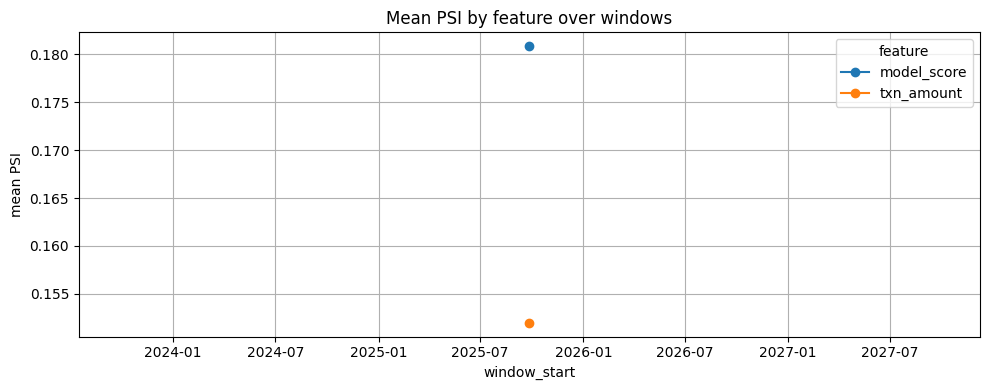

In [0]:
# Time-series plot: mean PSI per window by feature (matplotlib)
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

summary_table = "ml_drift_summary_v2"

sql = f"""
SELECT window_start, feature, AVG(psi) as mean_psi
FROM {summary_table}
WHERE psi IS NOT NULL
GROUP BY window_start, feature
ORDER BY window_start
"""
pdf = spark.sql(sql).toPandas()

if pdf.empty:
    print("No PSI rows found. Run the drift summary generation first.")
else:
    # convert window_start column to datetime
    pdf['window_start'] = pd.to_datetime(pdf['window_start'])
    # pivot so each feature is a column
    pivot = pdf.pivot(index='window_start', columns='feature', values='mean_psi').sort_index()
    plt.figure(figsize=(10,4))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker='o', label=col)
    plt.xlabel('window_start')
    plt.ylabel('mean PSI')
    plt.title('Mean PSI by feature over windows')
    plt.legend(title='feature')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


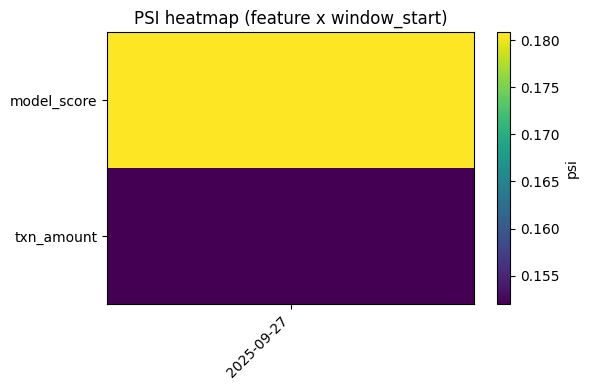

In [0]:
# Heatmap of PSI (feature x window_start)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

summary_table = "ml_drift_summary_v2"

sql = f"""
SELECT window_start, feature, psi
FROM {summary_table}
WHERE psi IS NOT NULL
ORDER BY window_start, feature
"""
pdf = spark.sql(sql).toPandas()

if pdf.empty:
    print("No PSI rows found. Run the drift summary generation first.")
else:
    pdf['window_start'] = pd.to_datetime(pdf['window_start'])
    # pivot
    pivot = pdf.pivot(index='feature', columns='window_start', values='psi')
    # Replace NaN with 0 for display
    matrix = pivot.fillna(0).values
    fig, ax = plt.subplots(figsize=(max(6, matrix.shape[1]*0.6), max(4, matrix.shape[0]*0.6)))
    im = ax.imshow(matrix, aspect='auto')  # do not set colors
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in pivot.columns], rotation=45, ha='right')
    ax.set_title('PSI heatmap (feature x window_start)')
    fig.colorbar(im, ax=ax, orientation='vertical', label='psi')
    plt.tight_layout()
    plt.show()


In [0]:
# ===============================================
# CELL A4.1 — Overview: Latest Drift Summary
# Replaced errorprone A4
# ===============================================
# Purpose:
#   Display the most recent drift summary and contextual metrics
#   This verifies that drift records were saved correctly to ml_drift_summary_v2.

from pyspark.sql import functions as F

summary_table = "ml_drift_summary_v2"
contrib_table = "ml_drift_contributions_v2"

print("✅ Latest drift summary entries:")
display(
    spark.table(summary_table)
         .orderBy(F.desc("collected_at"))
         .limit(20)
)

print("📊 Distinct monitoring windows available:")
display(
    spark.sql(f"SELECT DISTINCT window_start, window_end FROM {summary_table} ORDER BY window_start DESC")
)


✅ Latest drift summary entries:


feature,baseline_n,current_n,psi,ks,chi2,null_rate_change,window_start,window_end,collected_at
model_score,1150,100,0.180849,{0.10304347826086957},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z
txn_amount,1150,100,0.151988,{0.14782608695652166},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z


📊 Distinct monitoring windows available:


window_start,window_end
2025-09-27,2025-10-04


/home/spark-3dc39ac1-38aa-43f2-bcdf-d4/.ipykernel/2464/command-4583028534972340-3817304924:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


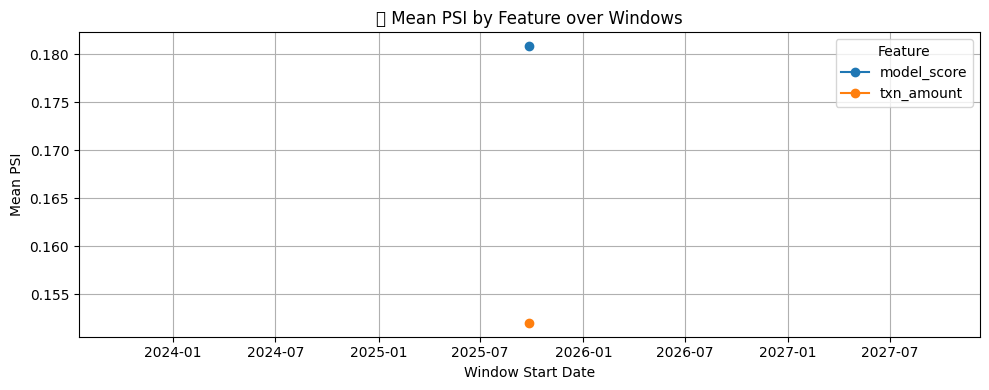

In [0]:
# ===============================================
# CELL A4.2 — PSI Trend Visualization (Matplotlib Line Chart)
# ===============================================
# Purpose:
#   Plot feature-wise PSI values over time
#   Use this to identify when a specific feature started drifting.

import pandas as pd
import matplotlib.pyplot as plt

sql = f"""
SELECT window_start, feature, AVG(psi) AS mean_psi
FROM ml_drift_summary_v2
WHERE psi IS NOT NULL
GROUP BY window_start, feature
ORDER BY window_start
"""
pdf = spark.sql(sql).toPandas()

if pdf.empty:
    print("⚠️ No PSI data found. Please re-run A3 to regenerate drift summary.")
else:
    pdf['window_start'] = pd.to_datetime(pdf['window_start'])
    pivot = pdf.pivot(index='window_start', columns='feature', values='mean_psi').sort_index()

    plt.figure(figsize=(10,4))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker='o', label=col)

    plt.xlabel("Window Start Date")
    plt.ylabel("Mean PSI")
    plt.title("📈 Mean PSI by Feature over Windows")
    plt.legend(title="Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [0]:
# ===============================================
# CELL A4.3B — Simulate multiple drift windows for visual testing
# ===============================================
import pandas as pd
import random
from datetime import datetime, timedelta

summary_table = "ml_drift_summary_v2"

# Load current PSI data
pdf = spark.table(summary_table).toPandas()

# Create 5 synthetic windows of PSI drift
base_date = datetime(2025, 9, 1)
synthetic = []
for i in range(5):
    w_date = base_date + timedelta(days=7*i)
    for feat in pdf["feature"].unique():
        psi_value = max(0, min(0.35, random.gauss(0.12 + 0.03*i, 0.02)))  # simulate slight drift each week
        synthetic.append({
            "feature": feat,
            "window_start": w_date.strftime("%Y-%m-%d"),
            "psi": psi_value
        })
synthetic_df = pd.DataFrame(synthetic)
display(synthetic_df)


feature,window_start,psi
model_score,2025-09-01,0.15365649923061275
txn_amount,2025-09-01,0.12693832030751576
model_score,2025-09-08,0.18320390906228387
txn_amount,2025-09-08,0.13596571507577973
model_score,2025-09-15,0.1755421858101371
txn_amount,2025-09-15,0.17895574699250413
model_score,2025-09-22,0.22656714704597714
txn_amount,2025-09-22,0.2019396629598099
model_score,2025-09-29,0.254187765569914
txn_amount,2025-09-29,0.255465526808259


/home/spark-3dc39ac1-38aa-43f2-bcdf-d4/.ipykernel/2464/command-4583028534972343-2286580406:33: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


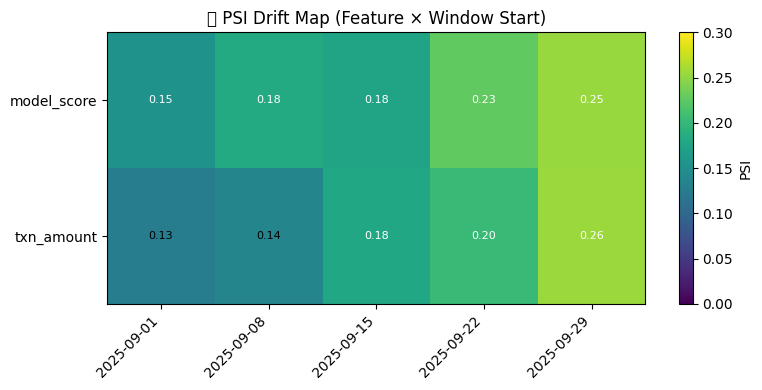

In [0]:
# ===============================================
# CELL A4.3C — Enhanced PSI Heatmap with value annotations
# ===============================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pdf = synthetic_df.copy()  # or use spark.table if you have real data
pdf['window_start'] = pd.to_datetime(pdf['window_start'])
pivot = pdf.pivot(index='feature', columns='window_start', values='psi').fillna(0)

# Define color intensity limits for PSI thresholds
vmin, vmax = 0, 0.3
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(pivot.values, aspect='auto', vmin=vmin, vmax=vmax)

# Axis labels
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in pivot.columns], rotation=45, ha='right')

# Annotate PSI values on heatmap
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        color = "white" if val > 0.15 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=8)

# Colorbar and labels
ax.set_title("🧭 PSI Drift Map (Feature × Window Start)")
fig.colorbar(im, ax=ax, label='PSI')
plt.tight_layout()
plt.show()


/home/spark-3dc39ac1-38aa-43f2-bcdf-d4/.ipykernel/2464/command-4583028534972344-11188586:33: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


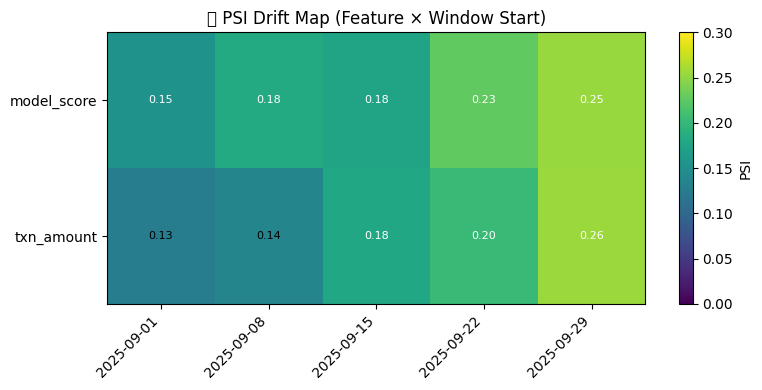

Legend:
🟢 PSI < 0.1 → No Drift
🟡 0.1 ≤ PSI < 0.25 → Moderate Drift
🔴 PSI ≥ 0.25 → High Drift


In [0]:
# ===============================================
# CELL A4.3C — Enhanced PSI Heatmap with value annotations
# ===============================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pdf = synthetic_df.copy()  # or use spark.table if you have real data
pdf['window_start'] = pd.to_datetime(pdf['window_start'])
pivot = pdf.pivot(index='feature', columns='window_start', values='psi').fillna(0)

# Define color intensity limits for PSI thresholds
vmin, vmax = 0, 0.3
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(pivot.values, aspect='auto', vmin=vmin, vmax=vmax)

# Axis labels
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in pivot.columns], rotation=45, ha='right')

# Annotate PSI values on heatmap
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        color = "white" if val > 0.15 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=8)

# Colorbar and labels
ax.set_title("🧭 PSI Drift Map (Feature × Window Start)")
fig.colorbar(im, ax=ax, label='PSI')
plt.tight_layout()
plt.show()

print("Legend:")
print("🟢 PSI < 0.1 → No Drift")
print("🟡 0.1 ≤ PSI < 0.25 → Moderate Drift")
print("🔴 PSI ≥ 0.25 → High Drift")



In [0]:
# CELL A5.1 — Extract latest drift summary snapshot for external monitoring
from pyspark.sql import functions as F

table_name = "ml_drift_summary_v2"

# Read full table and get latest window_start
df = spark.table(table_name)
latest_window = df.select(F.max("window_start")).collect()[0][0]

latest_drift_df = df.filter(F.col("window_start") == latest_window)

print(f"✅ Latest drift window: {latest_window}")
display(latest_drift_df)


✅ Latest drift window: 2025-09-27


feature,baseline_n,current_n,psi,ks,chi2,null_rate_change,window_start,window_end,collected_at
model_score,1150,100,0.180849,{0.10304347826086957},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z
txn_amount,1150,100,0.151988,{0.14782608695652166},null,0.0,2025-09-27,2025-10-04,2025-10-04T20:33:14.518Z


In [0]:
# CELL A5.2 — Convert drift summary to JSON records (with timestamp fix)

import json
import pandas as pd

# Convert Spark DF → Pandas DF
latest_drift_pd = latest_drift_df.toPandas()

# Convert any datetime/timestamp columns to ISO string
for col in latest_drift_pd.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns:
    latest_drift_pd[col] = latest_drift_pd[col].astype(str)

# Now safely convert to dict
latest_drift_json = latest_drift_pd.to_dict(orient="records")

# Pretty print JSON
print(json.dumps(latest_drift_json, indent=2))


[
  {
    "feature": "model_score",
    "baseline_n": 1150,
    "current_n": 100,
    "psi": 0.180849,
    "ks": "{0.10304347826086957}",
    "chi2": null,
    "null_rate_change": 0.0,
    "window_start": "2025-09-27",
    "window_end": "2025-10-04",
    "collected_at": "2025-10-04 20:33:14.518281"
  },
  {
    "feature": "txn_amount",
    "baseline_n": 1150,
    "current_n": 100,
    "psi": 0.151988,
    "ks": "{0.14782608695652166}",
    "chi2": null,
    "null_rate_change": 0.0,
    "window_start": "2025-09-27",
    "window_end": "2025-10-04",
    "collected_at": "2025-10-04 20:33:14.518281"
  }
]


In [0]:
# CELL A5.3 — Splunk HTTP Event Collector (HEC) Integration
# Note: Uncomment & configure if Splunk endpoint + token are available.

"""
import requests, json

# Replace with your Splunk HEC endpoint and token
SPLUNK_HEC_URL = "https://splunk.example.com:8088/services/collector"
SPLUNK_HEC_TOKEN = "Splunk <YOUR_HEC_TOKEN>"

headers = {"Authorization": SPLUNK_HEC_TOKEN, "Content-Type": "application/json"}

for record in latest_drift_json:
    payload = {
        "event": record,
        "sourcetype": "ml_drift_summary",
        "index": "mlops_observability",
        "time": record.get("window_start")
    }
    response = requests.post(SPLUNK_HEC_URL, headers=headers, data=json.dumps(payload))
    print(f"Sent {record['feature']} drift -> {response.status_code}")
"""


'\nimport requests, json\n\n# Replace with your Splunk HEC endpoint and token\nSPLUNK_HEC_URL = "https://splunk.example.com:8088/services/collector"\nSPLUNK_HEC_TOKEN = "Splunk <YOUR_HEC_TOKEN>"\n\nheaders = {"Authorization": SPLUNK_HEC_TOKEN, "Content-Type": "application/json"}\n\nfor record in latest_drift_json:\n    payload = {\n        "event": record,\n        "sourcetype": "ml_drift_summary",\n        "index": "mlops_observability",\n        "time": record.get("window_start")\n    }\n    response = requests.post(SPLUNK_HEC_URL, headers=headers, data=json.dumps(payload))\n    print(f"Sent {record[\'feature\']} drift -> {response.status_code}")\n'

In [0]:
# CELL A5.3 — Splunk HTTP Event Collector (HEC) Integration
# Note: Uncomment & configure if Splunk endpoint + token are available.

"""
import requests, json

# Replace with your Splunk HEC endpoint and token
SPLUNK_HEC_URL = "https://splunk.example.com:8088/services/collector"
SPLUNK_HEC_TOKEN = "Splunk <YOUR_HEC_TOKEN>"

headers = {"Authorization": SPLUNK_HEC_TOKEN, "Content-Type": "application/json"}

for record in latest_drift_json:
    payload = {
        "event": record,
        "sourcetype": "ml_drift_summary",
        "index": "mlops_observability",
        "time": record.get("window_start")
    }
    response = requests.post(SPLUNK_HEC_URL, headers=headers, data=json.dumps(payload))
    print(f"Sent {record['feature']} drift -> {response.status_code}")
"""


'\nimport requests, json\n\n# Replace with your Splunk HEC endpoint and token\nSPLUNK_HEC_URL = "https://splunk.example.com:8088/services/collector"\nSPLUNK_HEC_TOKEN = "Splunk <YOUR_HEC_TOKEN>"\n\nheaders = {"Authorization": SPLUNK_HEC_TOKEN, "Content-Type": "application/json"}\n\nfor record in latest_drift_json:\n    payload = {\n        "event": record,\n        "sourcetype": "ml_drift_summary",\n        "index": "mlops_observability",\n        "time": record.get("window_start")\n    }\n    response = requests.post(SPLUNK_HEC_URL, headers=headers, data=json.dumps(payload))\n    print(f"Sent {record[\'feature\']} drift -> {response.status_code}")\n'

In [0]:
# CELL A5.4 — Quick summary metadata for dashboard embedding
summary = {
    "latest_window": latest_window,
    "num_features": latest_drift_df.count(),
    "mean_psi": latest_drift_df.select(F.mean("psi")).collect()[0][0],
    "high_drift_features": latest_drift_df.filter(F.col("psi") > 0.25).count()
}
print("📊 Drift Telemetry Summary:", summary)


📊 Drift Telemetry Summary: {'latest_window': '2025-09-27', 'num_features': 2, 'mean_psi': 0.16641850000000002, 'high_drift_features': 0}


In [0]:
# ===========================
# A6.1 — Prepare governance payload (serverless-safe)
# ===========================
from pyspark.sql import functions as F
import pandas as pd
import traceback, sys

# CONFIG: adjust if your table name differs
SUMMARY_TABLE = "ml_drift_summary_v2"
MAX_ROWS_FOR_PANDAS = 10000   # safety limit for converting Spark -> pandas
RECENT_WINDOWS = 12           # how many recent windows to include in heatmap export

def safe_to_pandas(spark_df, max_rows=MAX_ROWS_FOR_PANDAS):
    """Convert a small spark DataFrame to pandas safely (with a row cap)."""
    cnt = spark_df.count()
    if cnt > max_rows:
        raise ValueError(f"Refusing to convert large DataFrame ({cnt} rows) to pandas. "
                         f"Set a larger MAX_ROWS_FOR_PANDAS if you know what you're doing.")
    return spark_df.toPandas()

try:
    # ---- 1) check table exists in current catalog
    tables = [t.name for t in spark.catalog.listTables()]
    if SUMMARY_TABLE not in tables:
        raise FileNotFoundError(f"Table '{SUMMARY_TABLE}' not found in current workspace/catalog. "
                                f"Available tables: {tables}")

    # ---- 2) load summary table
    df = spark.table(SUMMARY_TABLE)

    # ---- 3) quick emptiness check without rdd
    if df.limit(1).count() == 0:
        raise ValueError(f"Table '{SUMMARY_TABLE}' exists but is empty.")

    # ---- 4) determine latest window (robust fallbacks)
    latest_window = None
    if "window_start" in df.columns:
        latest_row = df.select(F.max("window_start").alias("latest_window")).collect()[0]
        latest_window = latest_row["latest_window"]
    elif "collected_at" in df.columns:
        latest_row = df.select(F.max("collected_at").alias("latest_window")).collect()[0]
        latest_window = latest_row["latest_window"]
    else:
        # final fallback: try to find any timestamp-like column to use as window
        ts_cols = [c for c, t in df.dtypes if 'timestamp' in t or 'date' in t]
        if ts_cols:
            latest_row = df.select(F.max(ts_cols[0]).alias("latest_window")).collect()[0]
            latest_window = latest_row["latest_window"]

    if latest_window is None:
        raise ValueError("Could not resolve a latest window. Check your table schema for 'window_start' or 'collected_at'.")

    # ---- 5) slice latest window
    latest_drift_df = df.filter(F.col("window_start") == latest_window) if "window_start" in df.columns else df.filter(F.col("collected_at") == latest_window)

    # ---- 6) build summary metadata
    mean_psi = None
    if "psi" in latest_drift_df.columns and latest_drift_df.limit(1).count() > 0:
        mean_psi = float(latest_drift_df.select(F.mean("psi")).collect()[0][0])
    summary_meta = {
        "latest_window": str(latest_window),
        "num_features": int(latest_drift_df.count()),
        "mean_psi": mean_psi,
        "high_drift_features": int(latest_drift_df.filter(F.col("psi") > 0.25).count()) if "psi" in latest_drift_df.columns else 0
    }

    # ---- 7) prepare top_drifts (safe, small)
    want_cols = ["feature","psi","baseline_n","current_n","null_rate_change","window_start","window_end"]
    exist_cols = [c for c in want_cols if c in latest_drift_df.columns]
    top_sdf = latest_drift_df.select(*exist_cols).orderBy(F.desc("psi")) if "psi" in latest_drift_df.columns else latest_drift_df.select(*exist_cols)
    top_sdf = top_sdf.limit(50)
    top_pd = safe_to_pandas(top_sdf)
    # convert pandas datetime columns to strings
    for c in top_pd.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns:
        top_pd[c] = top_pd[c].astype(str)
    top_drifts = top_pd.to_dict(orient="records")

    # ---- 8) prepare heatmap rows (recent windows only)
    heatmap_rows = []
    if "window_start" in df.columns:
        distinct_windows = [r[0] for r in df.select("window_start").distinct().orderBy(F.desc("window_start")).limit(RECENT_WINDOWS).collect()]
        heatmap_sdf = df.filter(F.col("window_start").isin(distinct_windows)).select("window_start","feature","psi").orderBy("window_start","feature")
        heatmap_pd = safe_to_pandas(heatmap_sdf)
        for c in heatmap_pd.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns:
            heatmap_pd[c] = heatmap_pd[c].astype(str)
        heatmap_rows = heatmap_pd.to_dict(orient="records")

    # ---- 9) final payload preview
    governance_payload = {
        "summary_meta": summary_meta,
        "top_drifts_count": len(top_drifts),
        "top_drifts_preview": top_drifts[:10],
        "heatmap_rows_count": len(heatmap_rows),
        "heatmap_rows_preview": heatmap_rows[:10]
    }

    print("A6.1 ✅ Prepared governance payload successfully.\n")
    print("Summary meta:", governance_payload["summary_meta"])
    print("\nTop drifts preview (up to 10 rows):")
    if governance_payload["top_drifts_preview"]:
        for r in governance_payload["top_drifts_preview"]:
            print(" ", r)
    else:
        print("  (no top drifts)")

    print("\nHeatmap preview (up to 10 rows):")
    if governance_payload["heatmap_rows_preview"]:
        for r in governance_payload["heatmap_rows_preview"]:
            print(" ", r)
    else:
        print("  (no heatmap rows)")

except Exception as e:
    print("A6.1 ❌ Failed to prepare governance payload.")
    traceback.print_exc(file=sys.stdout)
    raise


A6.1 ✅ Prepared governance payload successfully.

Summary meta: {'latest_window': '2025-09-27', 'num_features': 2, 'mean_psi': 0.16641850000000002, 'high_drift_features': 0}

Top drifts preview (up to 10 rows):
  {'feature': 'model_score', 'psi': 0.180849, 'baseline_n': 1150, 'current_n': 100, 'null_rate_change': 0.0, 'window_start': '2025-09-27', 'window_end': '2025-10-04'}
  {'feature': 'txn_amount', 'psi': 0.151988, 'baseline_n': 1150, 'current_n': 100, 'null_rate_change': 0.0, 'window_start': '2025-09-27', 'window_end': '2025-10-04'}

Heatmap preview (up to 10 rows):
  {'window_start': '2025-09-27', 'feature': 'model_score', 'psi': 0.180849}
  {'window_start': '2025-09-27', 'feature': 'txn_amount', 'psi': 0.151988}


In [0]:
# A6.2 (FALLBACK) — produce a downloadable JSON link (works even when DBFS/FileStore is disabled)
import json, base64, html, sys, traceback
from IPython.display import HTML, display

try:
    # Build dashboard JSON (reuse A6.1 variables if available)
    dashboard = {
        "dashboard_title": "ML Drift Governance Summary",
        "description": "Governance snapshot for model drift (PSI/KS). Generated by Spark_Drift_PlaybookV1.0",
        "summary": globals().get("summary_meta", {}),
        "top_drifts": globals().get("top_drifts", []),
        "heatmap_rows": globals().get("heatmap_rows", []),
        "notes": {
            "description": "Weekly drift dashboard for monitoring PSI & KS stability.",
            "next_steps": "Set up Splunk HEC / Databricks SQL alerts for psi > 0.25"
        }
    }

    json_txt = json.dumps(dashboard, indent=2, default=str)
    b64 = base64.b64encode(json_txt.encode()).decode()

    # Safe filename
    filename = "drift_governance_dashboard.json"

    # Build data URI / HTML link
    href = f'data:application/json;base64,{b64}'
    html_link = f'<a download="{html.escape(filename)}" href="{href}">⬇️ Download dashboard JSON (click)</a>'

    # Show link and a preview
    display(HTML(f"<div style='font-family: system-ui, sans-serif; padding:8px'>{html_link}</div>"))
    print("\nPreview (first 1000 chars):\n")
    print(json_txt[:1000] + ("\n\n... (truncated)" if len(json_txt) > 1000 else ""))

    # Extra helpful output (copy paste fallback)
    print("\nIf the download link does not work in your browser, copy the JSON below to a local file named 'drift_governance_dashboard.json':\n")
    print(json_txt)

except Exception:
    print("A6.2 ❌ Failed to generate download link. Showing full JSON as fallback.")
    traceback.print_exc(file=sys.stdout)
    try:
        print("\nFull JSON:\n")
        print(json_txt)
    except Exception:
        pass



Preview (first 1000 chars):

{
  "dashboard_title": "ML Drift Governance Summary",
  "description": "Governance snapshot for model drift (PSI/KS). Generated by Spark_Drift_PlaybookV1.0",
  "summary": {},
  "top_drifts": [],
  "heatmap_rows": [],
  "notes": {
    "description": "Weekly drift dashboard for monitoring PSI & KS stability.",
    "next_steps": "Set up Splunk HEC / Databricks SQL alerts for psi > 0.25"
  }
}

If the download link does not work in your browser, copy the JSON below to a local file named 'drift_governance_dashboard.json':

{
  "dashboard_title": "ML Drift Governance Summary",
  "description": "Governance snapshot for model drift (PSI/KS). Generated by Spark_Drift_PlaybookV1.0",
  "summary": {},
  "top_drifts": [],
  "heatmap_rows": [],
  "notes": {
    "description": "Weekly drift dashboard for monitoring PSI & KS stability.",
    "next_steps": "Set up Splunk HEC / Databricks SQL alerts for psi > 0.25"
  }
}


In [0]:
# --- UTILS (run once) For LinkedIn Article---
import json, base64, io, sys, traceback
from IPython.display import HTML, display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# create a downloadable data-uri link for bytes
def make_data_uri_download(bytes_data, filename, mime="application/octet-stream"):
    b64 = base64.b64encode(bytes_data).decode()
    href = f"data:{mime};base64,{b64}"
    html = f'<a download="{filename}" href="{href}">⬇️ Download {filename}</a>'
    display(HTML(html))

# safe conversion Spark->pandas with cap
def spark_to_pandas_safe(sdf, max_rows=10000):
    cnt = sdf.count()
    if cnt > max_rows:
        raise ValueError(f"DataFrame too large ({cnt} rows). Increase limit or sample.")
    return sdf.toPandas()



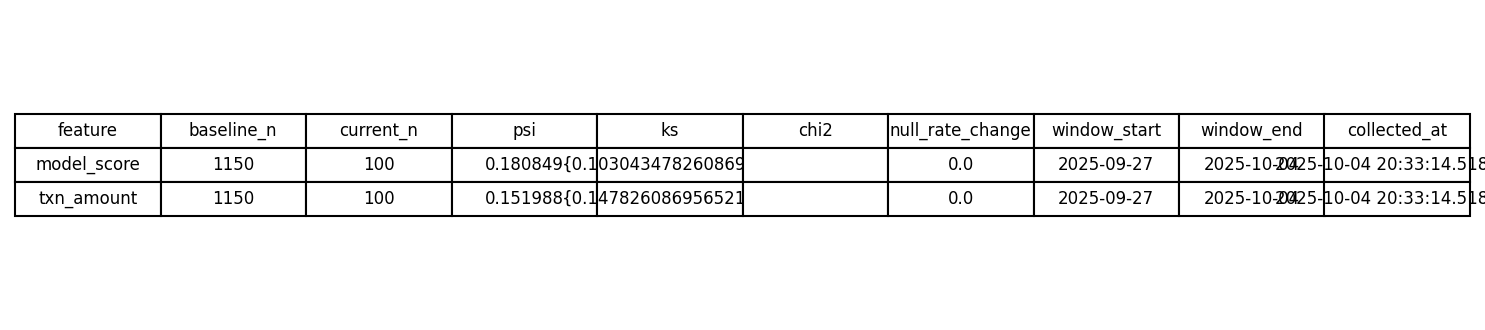

Saved psi_summary.csv and psi_summary_table.png (download links above).


In [0]:
# === ARTIFACT 1: PSI summary CSV + PNG ===
from pyspark.sql import functions as F
summary_table = "ml_drift_summary_v2"   # change if different
sdf = spark.table(summary_table).orderBy(F.desc("collected_at"), "feature")

# limit rows for article (e.g., last 50)
sdf_small = sdf.limit(200)
pdf = spark_to_pandas_safe(sdf_small)

# 1a) CSV bytes and download link
csv_bytes = pdf.to_csv(index=False).encode()
make_data_uri_download(csv_bytes, "psi_summary.csv", mime="text/csv")

# 1b) Render as image (matplotlib table)
fig, ax = plt.subplots(figsize=(10, min(0.4*len(pdf)+1.5, 12)))
ax.axis('off')
table = ax.table(cellText=pdf.values, colLabels=pdf.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
buf.seek(0)
img_bytes = buf.read()
make_data_uri_download(img_bytes, "psi_summary_table.png", mime="image/png")
plt.close(fig)
print("Saved psi_summary.csv and psi_summary_table.png (download links above).")



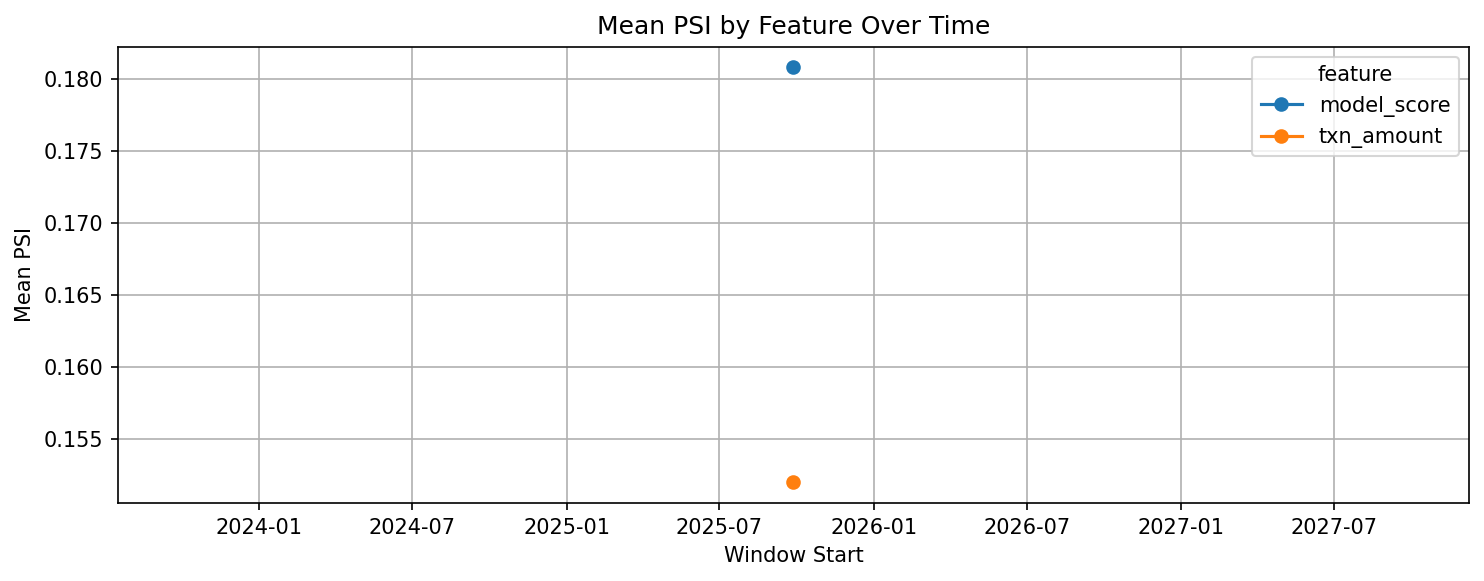

Downloaded psi_timeseries.png


In [0]:
# === ARTIFACT 2: PSI timeseries PNG ===
sql = f"""
SELECT window_start, feature, AVG(psi) as mean_psi
FROM ml_drift_summary_v2
WHERE psi IS NOT NULL
GROUP BY window_start, feature
ORDER BY window_start
"""
pdf = spark.sql(sql).toPandas()
if pdf.empty:
    print("No PSI rows found. Run A3/A6 steps first.")
else:
    pdf['window_start'] = pd.to_datetime(pdf['window_start'])
    pivot = pdf.pivot(index='window_start', columns='feature', values='mean_psi').sort_index()
    fig, ax = plt.subplots(figsize=(10,4))
    for col in pivot.columns:
        ax.plot(pivot.index, pivot[col], marker='o', label=col)
    ax.set_xlabel('Window Start')
    ax.set_ylabel('Mean PSI')
    ax.set_title('Mean PSI by Feature Over Time')
    ax.legend(title='feature')
    ax.grid(True)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    buf.seek(0)
    make_data_uri_download(buf.read(), "psi_timeseries.png", mime="image/png")
    plt.close(fig)
    print("Downloaded psi_timeseries.png")



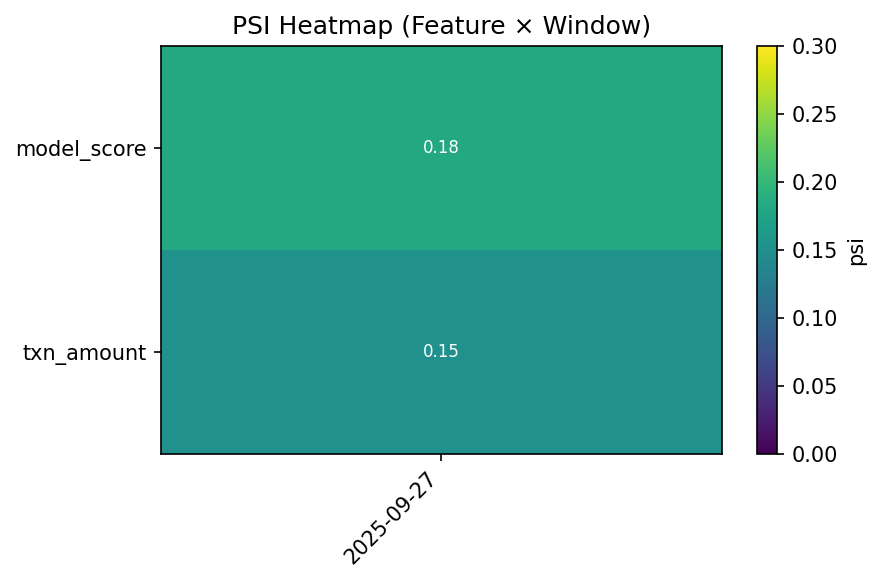

Downloaded psi_heatmap.png


In [0]:
# === ARTIFACT 3: PSI heatmap PNG ===
sql = f"SELECT window_start, feature, psi FROM ml_drift_summary_v2 WHERE psi IS NOT NULL ORDER BY window_start, feature"
pdf = spark.sql(sql).toPandas()
if pdf.empty:
    print("No PSI rows found. Run A3/A6 steps first.")
else:
    pdf['window_start'] = pd.to_datetime(pdf['window_start'])
    pivot = pdf.pivot(index='feature', columns='window_start', values='psi').fillna(0)
    matrix = pivot.values
    fig, ax = plt.subplots(figsize=(max(6, matrix.shape[1]*0.6), max(4, matrix.shape[0]*0.6)))
    im = ax.imshow(matrix, aspect='auto', vmin=0, vmax=max(0.3, matrix.max()))
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in pivot.columns], rotation=45, ha='right')
    # annotate
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            color = "white" if val > (0.15) else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=8)
    ax.set_title('PSI Heatmap (Feature × Window)')
    fig.colorbar(im, ax=ax, orientation='vertical', label='psi')
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    buf.seek(0)
    make_data_uri_download(buf.read(), "psi_heatmap.png", mime="image/png")
    plt.close(fig)
    print("Downloaded psi_heatmap.png")


In [0]:
# === ARTIFACT 4: Governance JSON (fresh download link) ===
# re-run the A6.1 logic to prepare summary_meta, top_drifts, heatmap_rows (quick version)
try:
    # attempt to reuse variables if present; otherwise rebuild minimal payload
    summary_meta = globals().get("summary_meta")
    top_drifts = globals().get("top_drifts")
    heatmap_rows = globals().get("heatmap_rows")
    if summary_meta is None:
        # small fallback: compute latest summary
        df = spark.table("ml_drift_summary_v2")
        latest_window = df.select(F.max("window_start")).collect()[0][0]
        latest_drift_df = df.filter(F.col("window_start") == latest_window)
        summary_meta = {
            "latest_window": str(latest_window),
            "num_features": int(latest_drift_df.count()),
            "mean_psi": float(latest_drift_df.select(F.mean("psi")).collect()[0][0]) if latest_drift_df.count() else None,
            "high_drift_features": int(latest_drift_df.filter(F.col("psi") > 0.25).count())
        }
        top_drifts = latest_drift_df.select("feature","psi","baseline_n","current_n","null_rate_change","window_start","window_end").orderBy(F.desc("psi")).limit(20).toPandas().to_dict(orient="records")
        heatmap_rows = spark.table("ml_drift_summary_v2").select("window_start","feature","psi").orderBy("window_start","feature").limit(2000).toPandas().to_dict(orient="records")
    dashboard = {"summary": summary_meta, "top_drifts": top_drifts, "heatmap_rows": heatmap_rows}
    json_txt = json.dumps(dashboard, indent=2, default=str)
    make_data_uri_download(json_txt.encode(), "drift_governance_dashboard.json", mime="application/json")
    print("Downloaded drift_governance_dashboard.json")
except Exception as e:
    print("Could not prepare governance JSON:", e)
    traceback.print_exc()


Downloaded drift_governance_dashboard.json
